In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import astropy.wcs
import astropy.units as u
from astropy.visualization import ImageNormalize, LogStretch, AsymmetricPercentileInterval
from ndcube import NDCube
import sunpy.map

from overlappy.util import color_lat_lon_axes, strided_array
from overlappy.io import read_overlappogram

# Testing rotational symmetry

The actual computation has been refactored into a standalone script so this notebook should be used to analyze the resulting images.

This is an experiment to understand whether we can account for 180 flips of the spacecraft by doing transposes of the final array in order to do coalignment.
We'll run the following the experiments

- original orientation of -90, flip 180
- original orientation of -75, flip 180
- original orientation of -90 with a grating roll of 25, flip 180

This means we need to build overlappograms with the following roll angles and dispersion angles $(\alpha, \gamma)$:

1. (-90, 0)
2. (90, 0)
3. (-75, 0)
4. (105, 0)
5. (-90, 25)
6. (90, 25)

If we can do this succesfully, 1 and 2 will be the same (within tolerance), 3 and 4, 5 and 6, in the case where we are applying the correct transpose operation to the first overlappogram in the pair.

In [2]:
def get_full_overlappogram(components, order):
    data = np.array([components[k].data[0] for k in components]).sum(axis=0)
    wcs = components[order].wcs
    data_strided = strided_array(data, components[order].data.shape[0])
    return NDCube(data_strided, wcs=wcs, unit=components[order].unit, meta=components[order].meta)

In [3]:
def plot_overlappogram(overlappogram):
    fig = plt.figure(figsize=(15,5))
    wave_index = 0
    ax = fig.add_subplot(111, projection=overlappogram[wave_index].wcs)
    plot_unit = 'ct / (pix h)'
    vmin, vmax = AsymmetricPercentileInterval(1,99.9).get_limits(
        u.Quantity(overlappogram[wave_index].data, overlappogram.unit).to_value(plot_unit),
    )
    overlappogram[wave_index].plot(
        axes=ax,
        cmap='hinodexrt',
        norm=ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch()),
        data_unit=plot_unit
    )
    color_lat_lon_axes(ax)

In [64]:
def difference_image(image_A, image_B):
    data_A = image_A.data[0]
    data_B = image_B.data[0]
    data_B_trans = data_B[::-1, ::-1]
    diff_ABtrans = data_A - data_B_trans
    diff_AB = data_A - data_B
    
    plt.figure(figsize=(20,15))
    plt.subplot(321)
    plt.imshow(data_A, origin='lower', norm=ImageNormalize(stretch=LogStretch()))
    plt.title('A')
    
    plt.subplot(322)
    plt.imshow(data_B, origin='lower', norm=ImageNormalize(stretch=LogStretch()))
    plt.title('B')
    
    plt.subplot(323)
    plt.imshow(data_B_trans, origin='lower', norm=ImageNormalize(stretch=LogStretch()))
    plt.title('B, flipped')
    
    plt.subplot(324)
    plt.imshow(diff_AB, origin='lower', norm=ImageNormalize(vmin=-5,vmax=5), cmap='RdBu',)
    plt.title('A - B')
    
    plt.subplot(325)
    plt.imshow(diff_ABtrans, origin='lower', norm=ImageNormalize(vmin=-5, vmax=5), cmap='RdBu',)
    plt.title('A - B (flipped)')
    
    plt.subplot(326)
    plt.hist(diff_AB.flatten(), histtype='step', label='A - B');
    plt.hist(diff_ABtrans.flatten(), histtype='step', label='A - B (flipped)');
    plt.legend();

In [59]:
orders = [-3, -1, 0, 1, 3]

In [60]:
root_dir = 'conops_testing/'
fn_temp = os.path.join(root_dir, 'roll{roll:.0f}_grating{grating:.0f}', 'overlappogram_ar_roll{roll:.0f}_grating{grating:.0f}_order{order:.0f}.fits')

## Case 1: Roll angle of $-90^\circ$, flipped by $180^\circ$ to $90^\circ$ 

In [61]:
image_A = get_full_overlappogram({o: read_overlappogram(fn_temp.format(roll=-90, grating=0, order=o)) for o in orders}, 0)
image_B = get_full_overlappogram({o: read_overlappogram(fn_temp.format(roll=90, grating=0, order=o)) for o in orders}, 0)

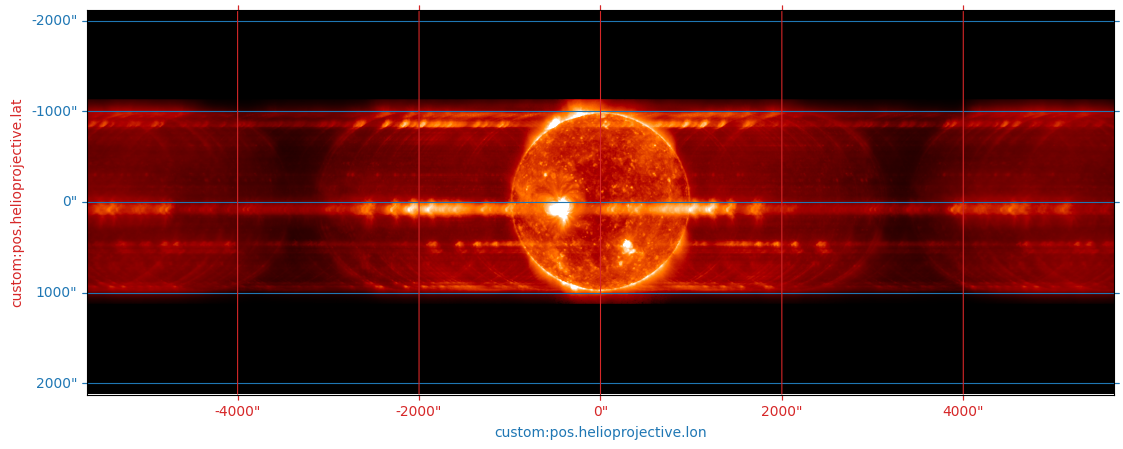

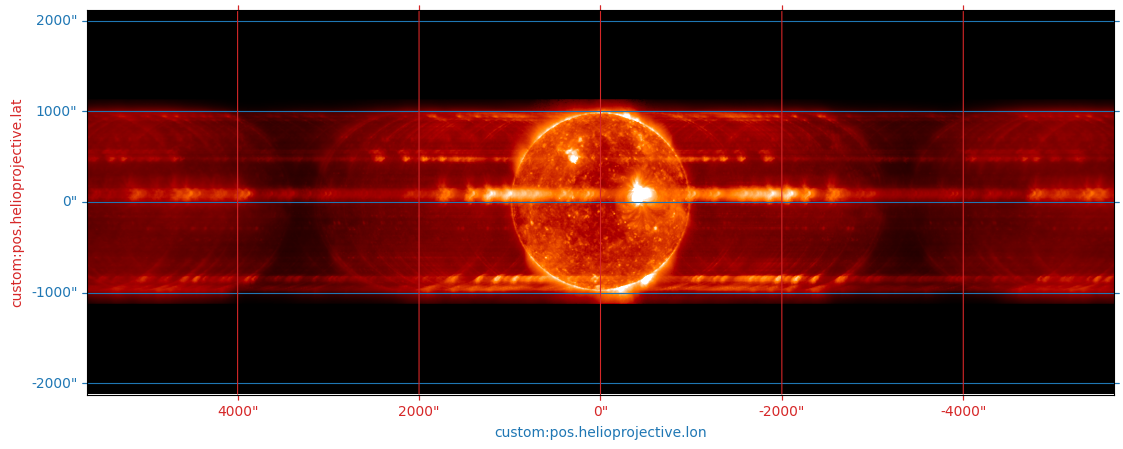

In [62]:
plot_overlappogram(image_A)
plot_overlappogram(image_B)

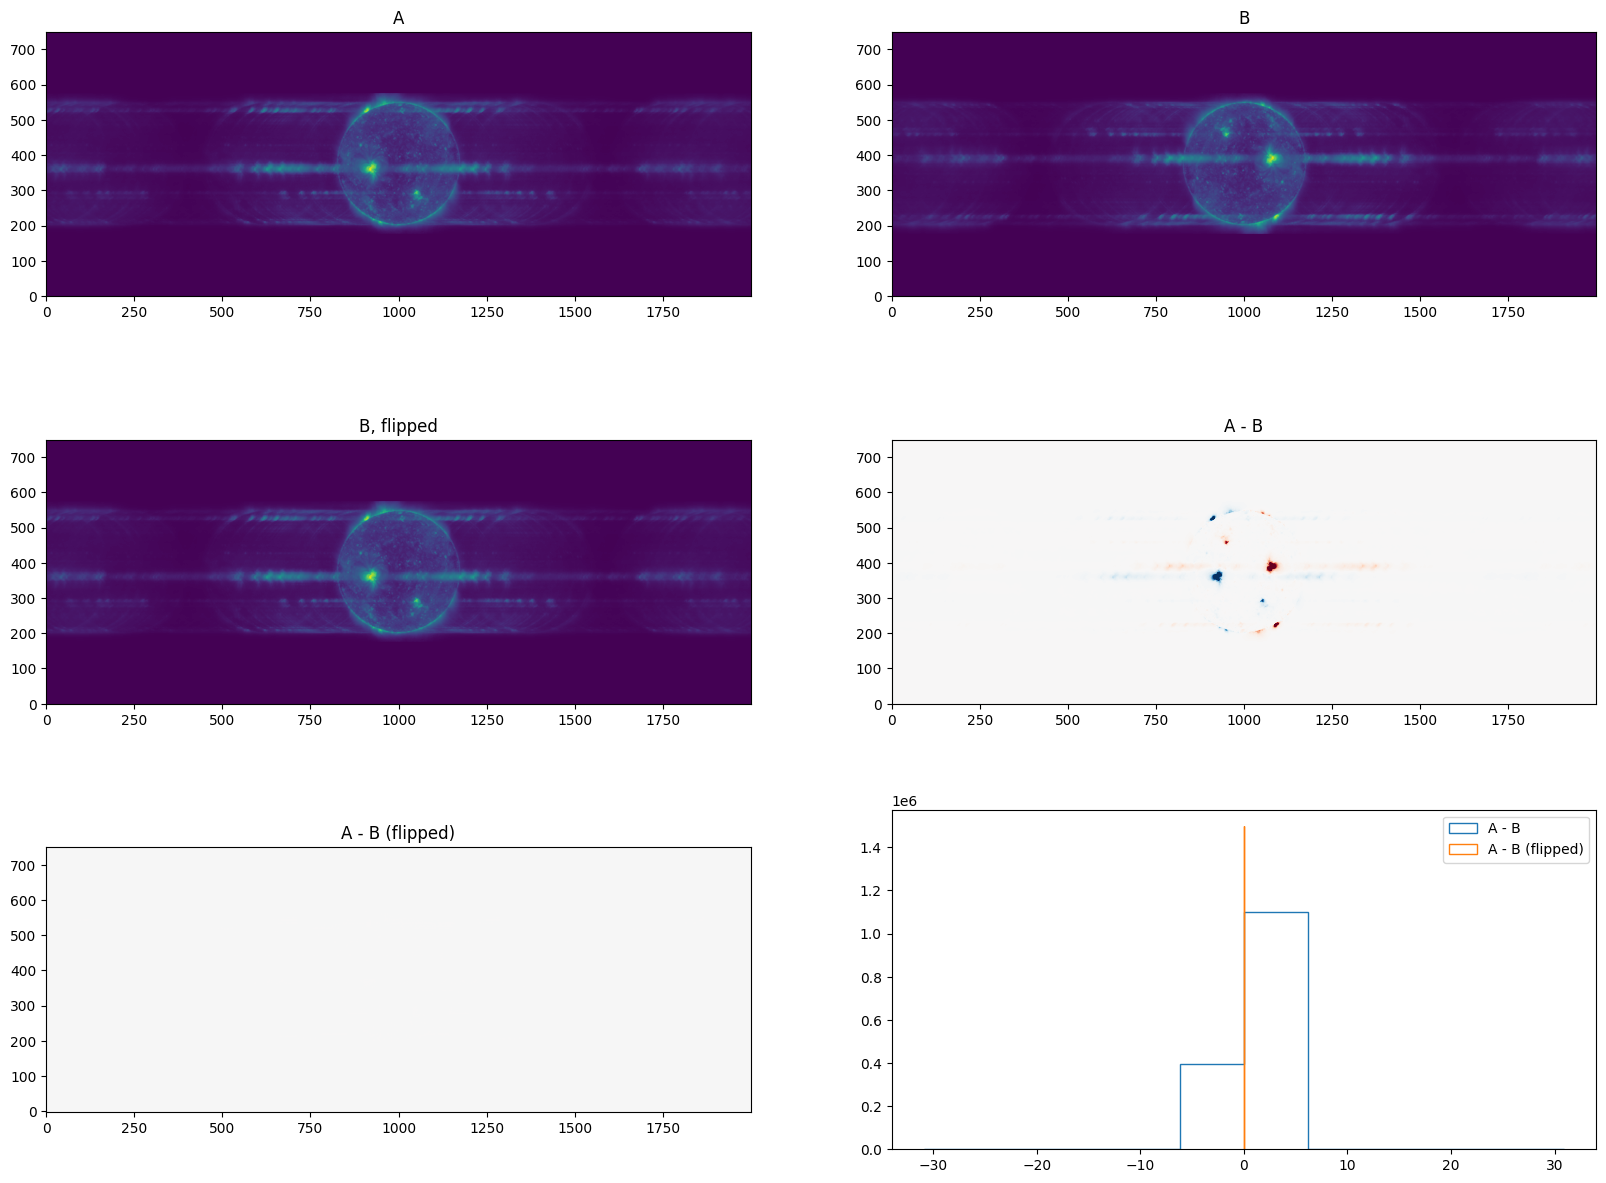

In [65]:
difference_image(image_A, image_B)

## Case 2: Roll angle of $-75^\circ$, flipped by $180^\circ$ to $105^\circ$ 

In [66]:
image_A = get_full_overlappogram({o: read_overlappogram(fn_temp.format(roll=-75, grating=0, order=o)) for o in orders}, 0)
image_B = get_full_overlappogram({o: read_overlappogram(fn_temp.format(roll=105, grating=0, order=o)) for o in orders}, 0)

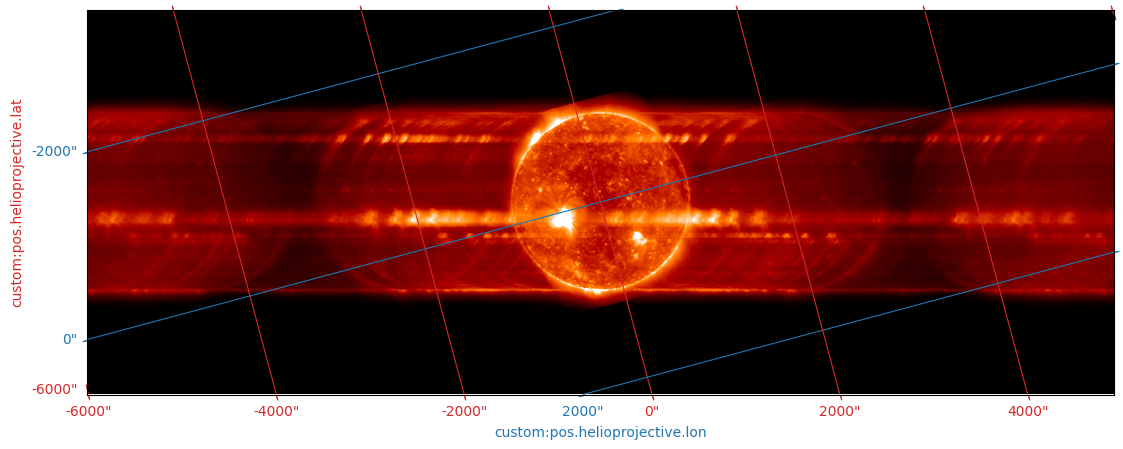

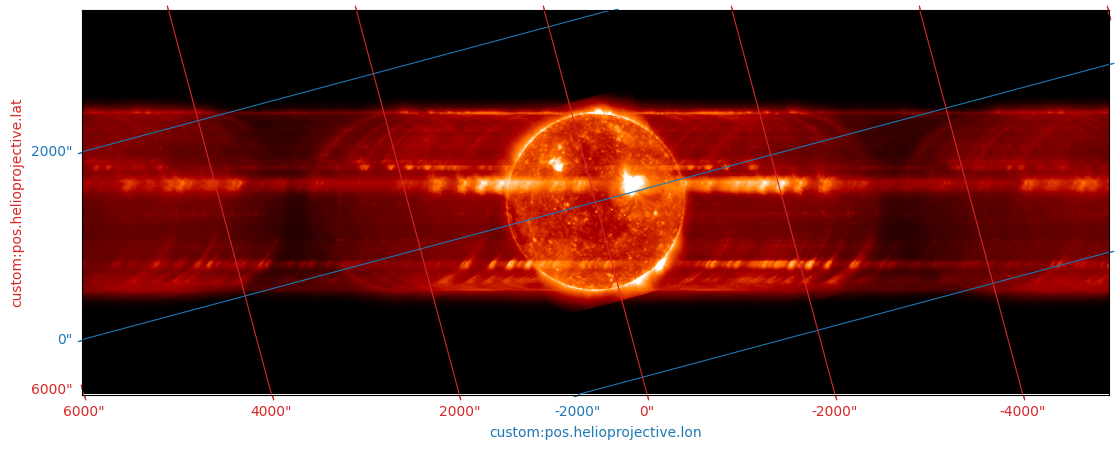

In [67]:
plot_overlappogram(image_A)
plot_overlappogram(image_B)

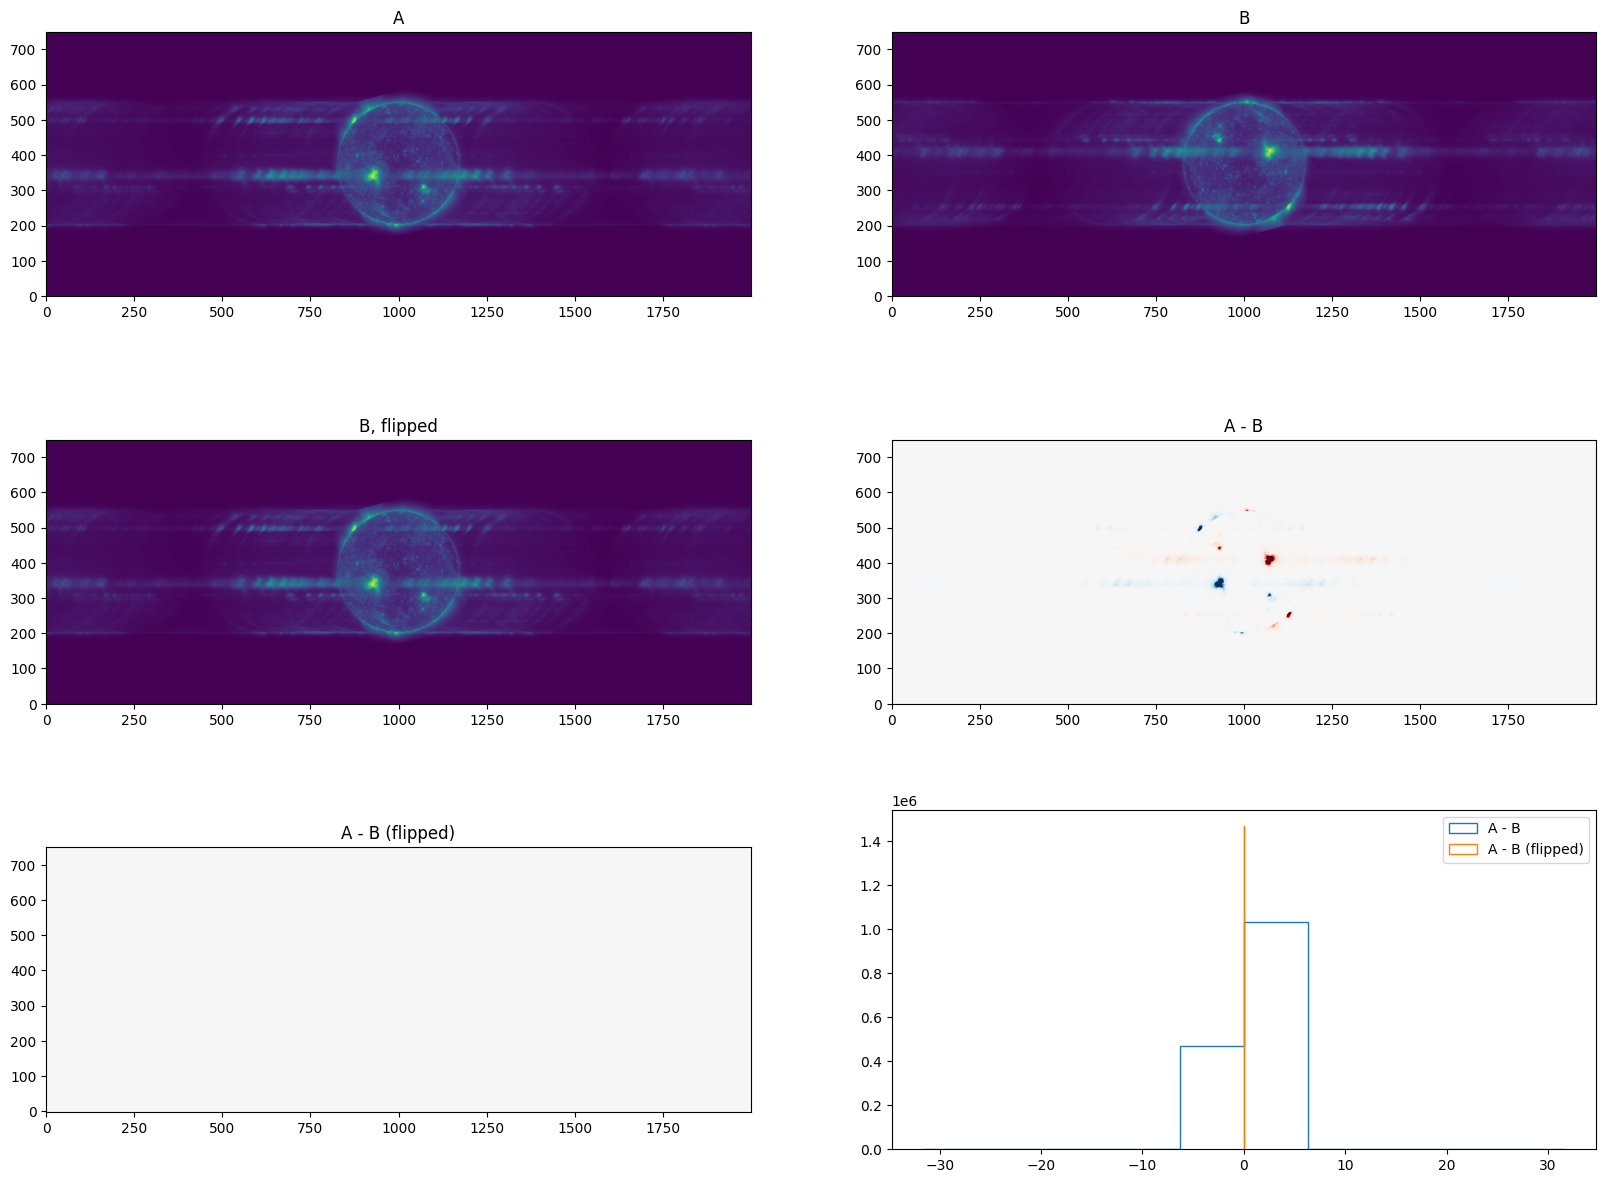

In [68]:
difference_image(image_A, image_B)

## Case 3: Roll angle of $-90^\circ$, flipped by $180^\circ$ to $90^\circ$ with a grating angle of $25^\circ$ 

In [69]:
image_A = get_full_overlappogram({o: read_overlappogram(fn_temp.format(roll=-90, grating=25, order=o)) for o in orders}, 0)
image_B = get_full_overlappogram({o: read_overlappogram(fn_temp.format(roll=90, grating=25, order=o)) for o in orders}, 0)

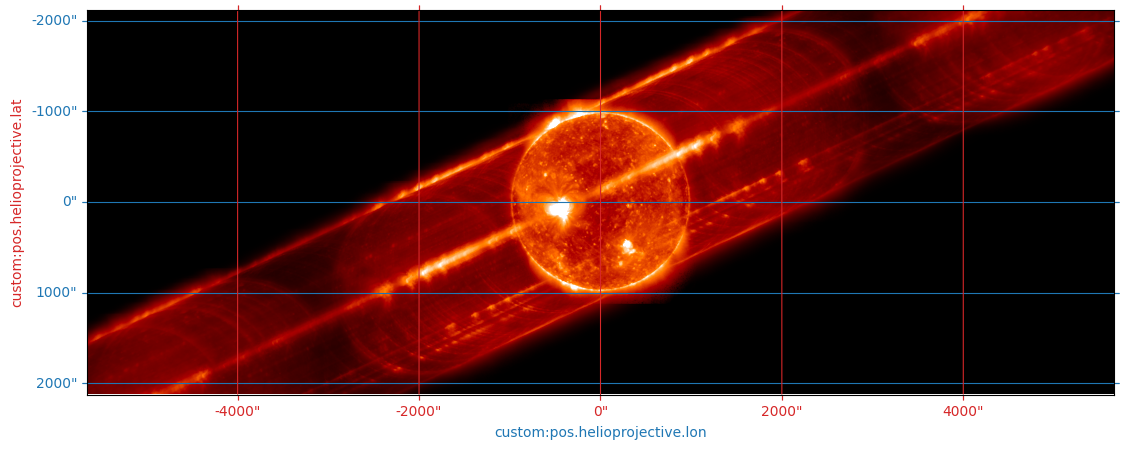

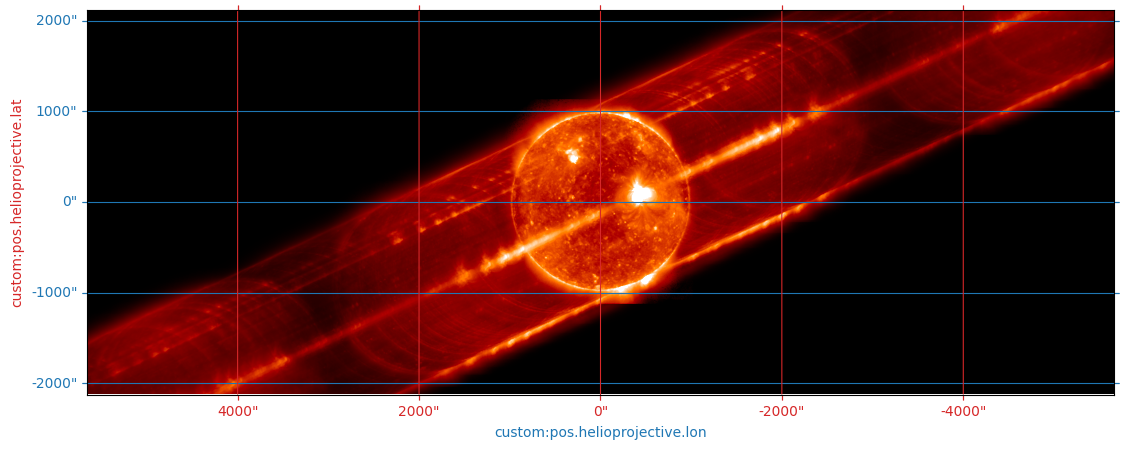

In [70]:
plot_overlappogram(image_A)
plot_overlappogram(image_B)

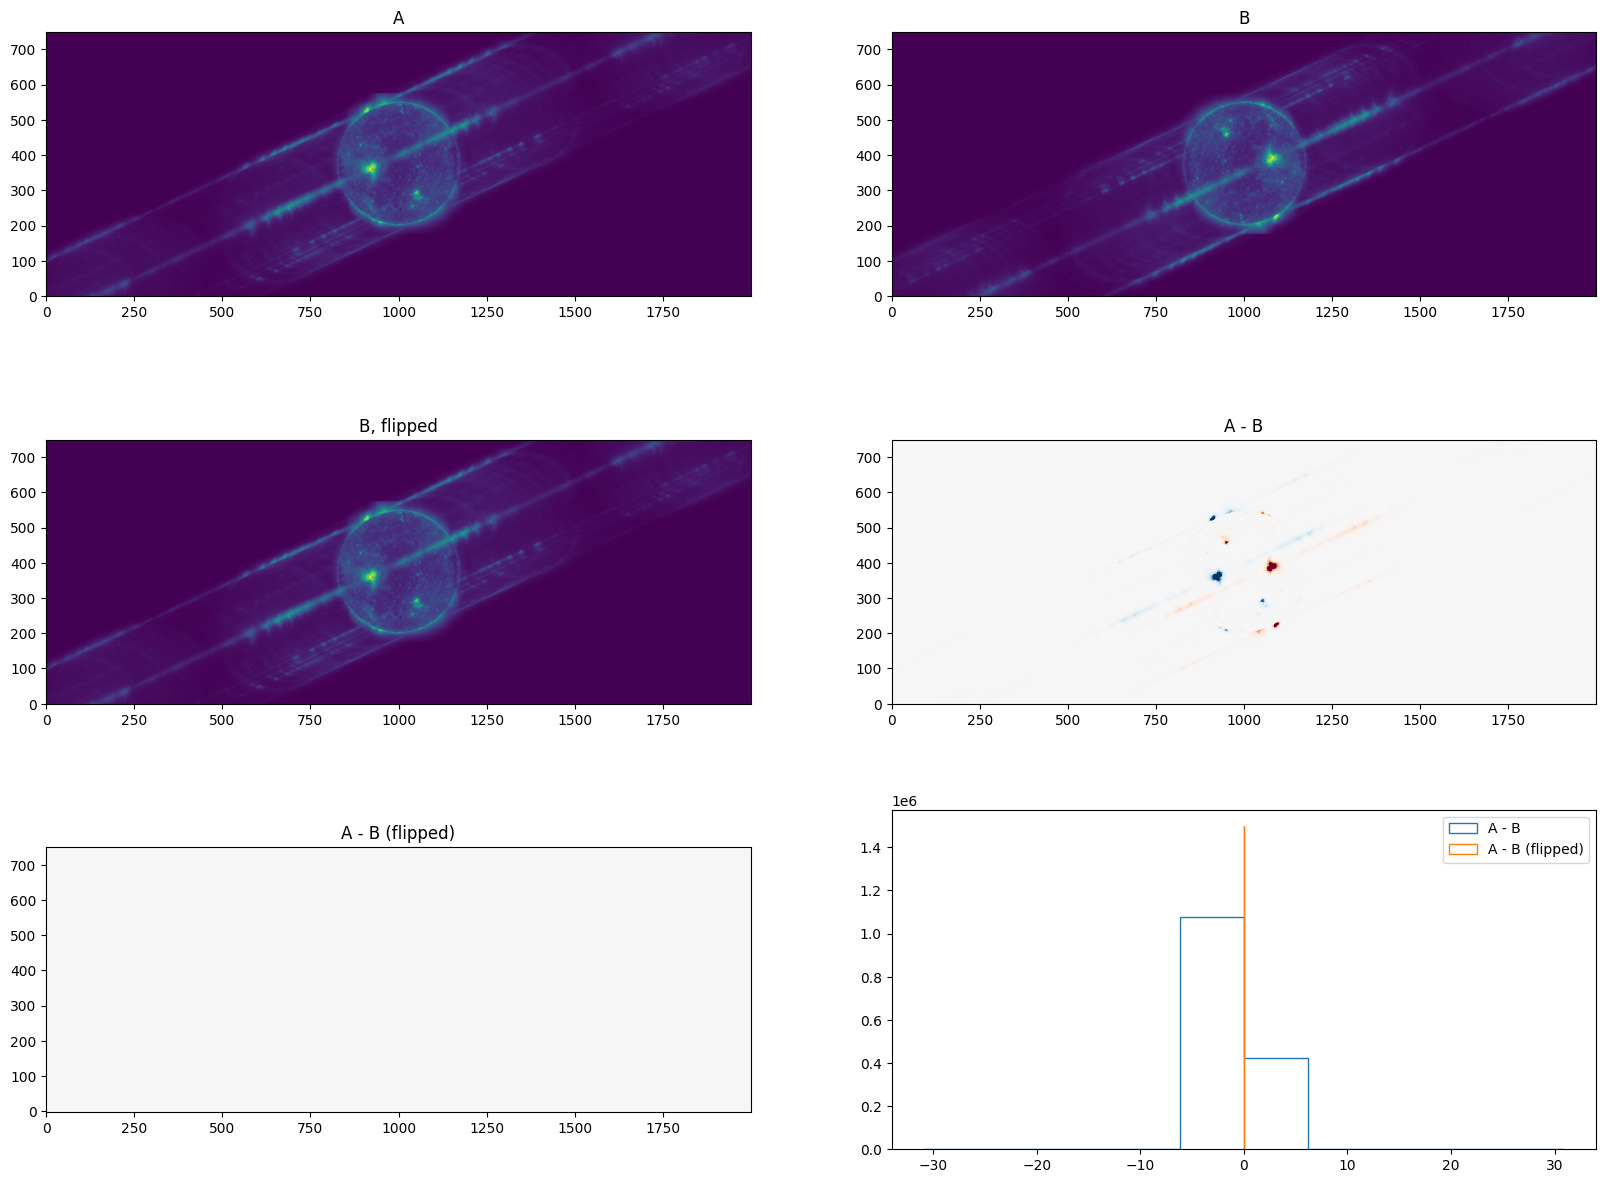

In [71]:
difference_image(image_A, image_B)

## TODOs

- what about a 90 flip?
- Animation?
  - Show a few different orientations between 90 and 180